# [TransferLearning](https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html)
> 실제로 충분한 크기의 데이터 셋을 갖추기는 어려움 -> 미리 학습된 신경망 사용해 초기 설정 또는 고정된 특징 추출기로 사용

- 전이학습 시나리오의 주요한 2가지
    - 합성곱 신경망의 미세조정(finetunig)
        > 무작위 초기화 대신, 미리 학습된 신경망으로 초기화
    - 고정된 특징 추출기로써의 합성곱 신경망
        > 마지막에 완전히 연결 된 계층을 제외한 모든 신경망의 가중치를 고정, 마지막만 weight 학습

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

### transforms
- 전처리를 위한 함수
- Compose를 통해 전처리를 여러개 진행할때 모아주는 역할

In [2]:
# resize crop -> Flip -> ToTensor(numpy 에서 Tensor로 바꿔 줌) -> Normalize
data_transform = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x ), data_transform[x])
                 for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 이미지 시각화

inputs shape : torch.Size([4, 3, 224, 224])
out shape : torch.Size([3, 228, 906])
imshowing...inp.shape : torch.Size([3, 228, 906])
imshowing...transpose...inp.shape : (228, 906, 3)


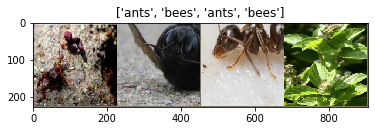

In [3]:
def imshow(inp, title=None):
    """
        imshow for Tensor
    """
    print(f'imshowing...inp.shape : {inp.shape}')
    inp = inp.numpy().transpose((1, 2, 0))
    print(f'imshowing...transpose...inp.shape : {inp.shape}')
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# 학습 데이터의 배치를 얻음    
inputs, classes = next(iter(dataloaders['train']))
print(f'inputs shape : {inputs.shape}')
# 배치로부터 격자 형태의 이미지를 만듬
out = torchvision.utils.make_grid(inputs)
print(f'out shape : {out.shape}')
imshow(out, title=[class_names[x] for x in classes])


## 모델 학습
- learning_rate 관리
- 최적의 모델
- `scheduler` 매개변수는 `torch.optim.lr_scheduler`의 LR 스케쥴러 Object

In [17]:
def train_model(model, creiterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'{epoch}/{num_epochs-1}')
        print('-' * 10)
        
        # 각 epoch은 학습 단계와 검증 단계를 가짐
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                # model을 train mode로 설정
                model.train()
            else:
                # model을 test mode로 설정
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            #데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()
                
                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss : {epoch_loss}, Acc : {epoch_acc}')
            
            # 모델을 깊은 복사
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc : {best_acc}')
    
    # 가장 나은 모델 가중치를 불러움
    model.load_state_dict(best_model_wts)
    return model

## 모델 예측값 시각화

In [23]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted : {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## finetuning

In [19]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 epoch마다 0.1씩 감소 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


### pip install torchsummary
- from torchsummary import summary

In [20]:
from torchsummary import summary
# summary(your_model, input_size=(channels, H, W))
summary(model_ft, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 학습 및 평가

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

0/19
----------
train Loss : 0.513432904100809, Acc : 0.7418032786885246
val Loss : 0.29714875945857927, Acc : 0.9019607843137255

1/19
----------
train Loss : 0.5806597634905675, Acc : 0.7377049180327869
val Loss : 0.2844854363429001, Acc : 0.8954248366013072

2/19
----------
train Loss : 0.4501272786836155, Acc : 0.8565573770491803
val Loss : 0.3588124237029381, Acc : 0.8562091503267975

3/19
----------
train Loss : 0.35569488709090186, Acc : 0.8565573770491803
val Loss : 0.36989084041975684, Acc : 0.8496732026143791

4/19
----------
train Loss : 0.4931618351428235, Acc : 0.8360655737704918
val Loss : 0.5941543053178227, Acc : 0.7908496732026145

5/19
----------
train Loss : 0.6008528111899485, Acc : 0.819672131147541
val Loss : 0.5292379665218927, Acc : 0.8431372549019608

6/19
----------
train Loss : 0.4130371278915249, Acc : 0.8237704918032788
val Loss : 0.3728109547515321, Acc : 0.8954248366013072

7/19
----------
train Loss : 0.26043441549676366, Acc : 0.8975409836065574
val Los

imshowing...inp.shape : torch.Size([3, 224, 224])
imshowing...transpose...inp.shape : (224, 224, 3)


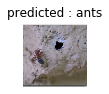

imshowing...inp.shape : torch.Size([3, 224, 224])
imshowing...transpose...inp.shape : (224, 224, 3)


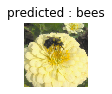

imshowing...inp.shape : torch.Size([3, 224, 224])
imshowing...transpose...inp.shape : (224, 224, 3)


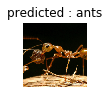

imshowing...inp.shape : torch.Size([3, 224, 224])
imshowing...transpose...inp.shape : (224, 224, 3)


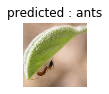

imshowing...inp.shape : torch.Size([3, 224, 224])
imshowing...transpose...inp.shape : (224, 224, 3)


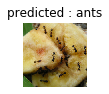

imshowing...inp.shape : torch.Size([3, 224, 224])
imshowing...transpose...inp.shape : (224, 224, 3)


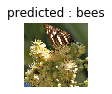

In [24]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정
    - `requires_grad == False`로 설정하여 매개변수를 고정
    - backward()중에 경사도가 계산되지 않도록 해야함

In [28]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad = True임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 epoch마다 0.1씩 learning_rate 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## 학습 및 평가

In [34]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=20)

0/19
----------


C:\ProgramData\Anaconda3\envs\pytch_env\lib\site-packages\torch\optim\lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss : 0.6964263828074346, Acc : 0.5942622950819673
val Loss : 0.2048309534982918, Acc : 0.934640522875817

1/19
----------
train Loss : 0.46375295202263067, Acc : 0.7868852459016393
val Loss : 0.2866038594370574, Acc : 0.888888888888889

2/19
----------
train Loss : 0.5351572615689919, Acc : 0.7418032786885246
val Loss : 0.2082682805123672, Acc : 0.9281045751633987

3/19
----------
train Loss : 0.5959379177113049, Acc : 0.75
val Loss : 0.17210878967459686, Acc : 0.9477124183006537

4/19
----------
train Loss : 0.4615624761972271, Acc : 0.7745901639344263
val Loss : 0.20340419672673044, Acc : 0.934640522875817

5/19
----------
train Loss : 0.44163564531529537, Acc : 0.8114754098360656
val Loss : 0.25786688475826985, Acc : 0.888888888888889

6/19
----------
train Loss : 0.5240568943688126, Acc : 0.7909836065573771
val Loss : 0.18399280816121819, Acc : 0.9477124183006537

7/19
----------
train Loss : 0.39113711138240626, Acc : 0.8360655737704918
val Loss : 0.2107326201364106, Acc :

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()